In this notebook, we explore the benefits of adding depths separable convolutions to the legacy AnalogNet.  We train networks with growing number of depth-separable layers, compare their accuracy, and output their weights.
This is done in view of eventually comparing their accuracy once implemented on the SCAMP5 camera, and demonstrate the noxious effects of noise.

 * Legacy (one layer), reg then bin: 96.7% final testing accuracy (after FC retraining).
 * Legacy (one layer), bin then reg: 97.1% final testing accuracy (after FC retraining).


 * One layer + one depth separable conv, bin then reg: 96.9% final testing accuracy with ReLU, 97.6% with lReLU0.2, 97.2% with lReLU0.25 (after FC retraining) (97.3% before rounding)

 * One layer + two depth separable conv, bin then reg: 97.6% with lReLU.2 (97.9% before rounding + FC retrain), 97.62% with lReLU.25 (after FC retraining)

BEWARE: checkpoint file names are interchanged between .2 and .25 ReLU versions... For this version of the network (one layer + 2 depth sep conv layers), all files with the name .2 are in fact referring to the version using .25 ReLU, and vice-versa


 * One layer + three depth separable conv, bin then reg: 97.69% with lReLU.25 (after FC retraining)

In [0]:
!nvidia-smi

Sat Jul 27 13:23:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    60W / 149W |    397MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
EPOCHS = 50
BATCH_SIZE = 100
LR = 0.001

ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 4.

MAX_BIN_RATE = 10

BATCH_SIZE_FC = 50
LR_FC = 0.0001
EPOCHS_FC = 100

# 0 Import data and utils

In [0]:
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Simulate an input binarization
x_train = np.minimum(x_train, 100) // 100 * 120
x_test = np.minimum(x_test, 100) // 100 * 120

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1)
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

In [0]:
def test_accuracy_bin_rate_fc(bin_rate_feed, verbose=False):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE_FC)
  for i in range(x_test.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    
    xs = np.expand_dims(x_test[start:stop],-1)
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  if verbose:
    print('Testing Acc.: {}'.format(
          accs.mean()))
  return accs.mean()

In [0]:
def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

# 1 Legacy AnalogNet architecture

## 1.1 Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

NUM_PARAM_REG = 3*3*3
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 1.2 Training

In [0]:
"""
# Reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
"""

'\n# Reg then bin\nfor epoch in range(EPOCHS*12):\n  if epoch < EPOCHS * 4:\n    lr_feed = LR\n    reg_factor_feed = 0.\n    bin_rate_feed = 1.\n  elif epoch < EPOCHS * 8:\n    lr_feed = LR / 2.\n    reg_factor_feed = REG_CONSTANT\n    bin_rate_feed = 1.\n  else:\n    lr_feed = LR / 4.\n    reg_factor_feed = REG_CONSTANT\n    bin_rate_feed = MAX_BIN_RATE + 1\n    \n# Bin then reg\nfor epoch in range(EPOCHS*12):\n  if epoch < EPOCHS * 4:\n    lr_feed = LR\n    reg_factor_feed = 0.\n    bin_rate_feed = 1.\n  elif epoch < EPOCHS * 8:\n    lr_feed = LR / 2.\n    reg_factor_feed = 0.\n    bin_rate_feed = MAX_BIN_RATE + 1\n  else:\n    lr_feed = LR / 4.\n    reg_factor_feed = REG_CONSTANT\n    bin_rate_feed = MAX_BIN_RATE + 1\n'

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 2.0680494263768194
Testing Acc.: 0.7577000004053116
Epoch 2 completed, average training loss is 0.5831879838804404
Testing Acc.: 0.861299996972084
Epoch 3 completed, average training loss is 0.4130582828323046
Testing Acc.: 0.8961000019311904
Epoch 4 completed, average training loss is 0.3287145089358091
Testing Acc.: 0.9179000014066696
Epoch 5 completed, average training loss is 0.2769527878984809
Testing Acc.: 0.9146000015735626
Epoch 6 completed, average training loss is 0.252747854180634
Testing Acc.: 0.9347000056505204
Epoch 7 completed, average training loss is 0.23438403521974882
Testing Acc.: 0.9328000044822693
Epoch 8 completed, average training loss is 0.21904095391432443
Testing Acc.: 0.9307000070810318
Epoch 9 completed, average training loss is 0.2063939405977726
Testing Acc.: 0.9437000030279159
Epoch 10 completed, average training loss is 0.20189126927405596
Testing Acc.: 0.9452000069618225
Epoch 11 completed, average training l

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9653000056743621


In [0]:
# Save models, for not having to fully retrain it each time.

# Testing Acc.: 0.9635000038146972
saver = tf.train.Saver()
saver.save(sess, 'one_layer_bin_reg/model.ckpt')

'one_layer_bin_reg/model.ckpt'

In [0]:
!zip -r one_layer_bin_reg.zip one_layer_bin_reg

  adding: one_layer_bin_reg/ (stored 0%)
  adding: one_layer_bin_reg/.ipynb_checkpoints/ (stored 0%)
  adding: one_layer_bin_reg/checkpoint (deflated 42%)
  adding: one_layer_bin_reg/model.ckpt.index (deflated 40%)
  adding: one_layer_bin_reg/model.ckpt.data-00000-of-00001 (deflated 11%)
  adding: one_layer_bin_reg/model.ckpt.meta (deflated 88%)


## 1.3 Re-training FC after rounding the conv kernels

In [0]:
!unzip one_layer_bin_reg.zip

Archive:  one_layer_bin_reg.zip
   creating: one_layer_bin_reg/
   creating: one_layer_bin_reg/.ipynb_checkpoints/
  inflating: one_layer_bin_reg/checkpoint  
  inflating: one_layer_bin_reg/model.ckpt.index  
  inflating: one_layer_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: one_layer_bin_reg/model.ckpt.meta  


### 1.3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('one_layer_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9653000003099441

### 1.3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

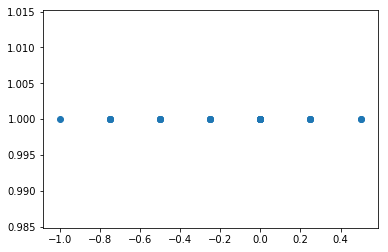

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


### 1.3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.2145366787817329
Testing Acc.: 0.9482999983429908
Epoch 2 completed, average training loss is 0.15766290468629449
Testing Acc.: 0.9535000005364418
Epoch 3 completed, average training loss is 0.14483649748455113
Testing Acc.: 0.9536999985575676
Epoch 4 completed, average training loss is 0.1369334893107104
Testing Acc.: 0.9596999987959862
Epoch 5 completed, average training loss is 0.13109906054722767
Testing Acc.: 0.9556999987363816
Epoch 6 completed, average training loss is 0.12682948484706383
Testing Acc.: 0.9597999978065491
Epoch 7 completed, average training loss is 0.12426246909075417
Testing Acc.: 0.9629000014066696
Epoch 8 completed, average training loss is 0.12239369432247865
Testing Acc.: 0.9609999993443489
Epoch 9 completed, average training loss is 0.1190031525104617
Testing Acc.: 0.9606999999284744
Epoch 10 completed, average training loss is 0.11696479230071417
Testing Acc.: 0.9612999993562699
Epoch 11 completed, average trai

NameError: ignored

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9715000021457673


## 1.4 Extract conv weights

In [0]:
w1_values

array([[[[ 0.  ,  0.  , -0.25]],

        [[ 0.5 ,  0.5 ,  0.25]],

        [[ 0.  , -0.75, -0.75]]],


       [[[ 0.25,  0.25,  0.25]],

        [[ 0.  ,  0.  ,  0.  ]],

        [[ 0.  , -1.  , -0.75]]],


       [[[-0.25, -0.25, -0.25]],

        [[-0.5 , -0.5 , -0.75]],

        [[-0.5 ,  0.  , -0.5 ]]]], dtype=float32)

In [0]:
sess.run(thresh)

array([1.007131  , 0.9427277 , 0.22156298], dtype=float32)

In [0]:
with open('NP_WEIGHTS_one_layer_bin_reg.pck', 'wb') as f:
  pickle.dump(w1_values, f)

# 2 Add 1 depth separable conv layer

## 2.1 Network definition

In [0]:
def lrelu(x):
    return tf.maximum(x * 0.25, x)

In [0]:
# Define the network
def net2(input, thresh_ph, bin_rate_ph):
  # Convolution
  #conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
  #                   padding='SAME', scope='conv1')
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv1')
  
  # One depth separable conv
  conv_2_1 = slim.conv2d(conv[...,:1], 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv2_1')
  conv_2_2 = slim.conv2d(conv[...,1:2], 1, [3, 3], rate=1, activation_fn=None,
                   padding='SAME', scope='conv2_2')
  conv_2_3 = slim.conv2d(conv[...,2:3], 1, [3, 3], rate=1, activation_fn=None,
                 padding='SAME', scope='conv2_3')
  
  conv2 = tf.concat([conv_2_1, conv_2_2, conv_2_3], axis=-1)
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv2, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net2(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2_1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
with tf.variable_scope('conv2_2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
with tf.variable_scope('conv2_3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')

NUM_PARAM_REG = np.prod(([int(e) for e in w1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_3.shape]))

reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 2.2 Training

In [0]:
"""
# Reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
"""

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)
  

Epoch 1 completed, average training loss is 2.886536486744881
Testing Acc.: 0.7596999961137771
Epoch 2 completed, average training loss is 0.6441367170711358
Testing Acc.: 0.8499999970197678
Epoch 3 completed, average training loss is 0.45208872710665066
Testing Acc.: 0.8816000014543534
Epoch 4 completed, average training loss is 0.34279852952808143
Testing Acc.: 0.9091000020503998
Epoch 5 completed, average training loss is 0.28124705590307714
Testing Acc.: 0.9287000024318695
Epoch 6 completed, average training loss is 0.24822778546561797
Testing Acc.: 0.9215000021457672
Epoch 7 completed, average training loss is 0.22532825889686744
Testing Acc.: 0.9329000020027161
Epoch 8 completed, average training loss is 0.21488992650061844
Testing Acc.: 0.9390000033378602
Epoch 9 completed, average training loss is 0.20569331142430505
Testing Acc.: 0.9452000051736832
Epoch 10 completed, average training loss is 0.190717726846536
Testing Acc.: 0.9495000058412552
Epoch 11 completed, average traini

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9735000061988831


In [0]:
# Save models, for not having to fully retrain it each time.

# Testing Acc.: 0.9714000046253204 for bin reg
# 0.9679000043869018 for reg bin
saver = tf.train.Saver()
saver.save(sess, 'two_layers_bin_reg_lrelu025/model.ckpt')

'two_layers_bin_reg_lrelu025/model.ckpt'

In [0]:
!zip -r two_layers_bin_reg_lrelu025.zip two_layers_bin_reg_lrelu025

  adding: two_layers_bin_reg_lrelu025/ (stored 0%)
  adding: two_layers_bin_reg_lrelu025/model.ckpt.index (deflated 50%)
  adding: two_layers_bin_reg_lrelu025/model.ckpt.meta (deflated 89%)
  adding: two_layers_bin_reg_lrelu025/model.ckpt.data-00000-of-00001 (deflated 15%)
  adding: two_layers_bin_reg_lrelu025/checkpoint (deflated 42%)


## 2.3 Re-training FC after rounding the conv kernels

### 2.3.1 Reload Network

In [0]:
!unzip two_layers_bin_reg_lrelu.zip

Archive:  two_layers_bin_reg.zip
   creating: two_layers_bin_reg/
  inflating: two_layers_bin_reg/model.ckpt.index  
  inflating: two_layers_bin_reg/model.ckpt.meta  
  inflating: two_layers_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: two_layers_bin_reg/checkpoint  


In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net2(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('two_layers_bin_reg_lrelu')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9747000023722648

### 2.3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2_1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
with tf.variable_scope('conv2_2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
with tf.variable_scope('conv2_3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')

Testing Acc.: 0.9437999960780143


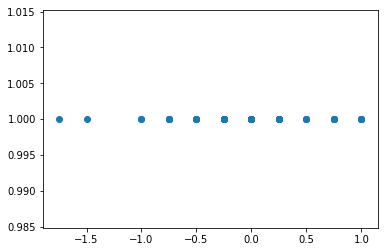

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias1_op = tf.assign(b1, 
                          tf.round(b1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_1_op = tf.assign(w2_1, 
                          tf.round(w2_1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights2_2_op = tf.assign(w2_2, 
                          tf.round(w2_2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights2_3_op = tf.assign(w2_3, 
                          tf.round(w2_3/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)
_ = sess.run(rounding_bias1_op)
_ = sess.run(rounding_weights2_1_op)
_ = sess.run(rounding_weights2_2_op)
_ = sess.run(rounding_weights2_3_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)
b1_values = sess.run(b1)
w2_1_values = sess.run(w2_1)
w2_2_values = sess.run(w2_2)
w2_3_values = sess.run(w2_3)

kernel_values = (list(w1_values.flatten()) + 
                  list(b1_values.flatten()) +
                  list(w2_1_values.flatten()) +
                  list(w2_2_values.flatten()) +
                  list(w2_3_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))

### 2.3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)


Epoch 1 completed, average training loss is 0.09879713208123576
Testing Acc.: 0.9676000002026558
Epoch 2 completed, average training loss is 0.09245946752266415
Testing Acc.: 0.9640999987721444
Epoch 3 completed, average training loss is 0.08843672130926279
Testing Acc.: 0.9680000004172326
Epoch 4 completed, average training loss is 0.08753748751507373
Testing Acc.: 0.9665000000596047
Epoch 5 completed, average training loss is 0.08626345378856058
Testing Acc.: 0.9671000000834465
Epoch 6 completed, average training loss is 0.08527869787319409
Testing Acc.: 0.9667000007629395
Epoch 7 completed, average training loss is 0.08397473235711611
Testing Acc.: 0.9669000005722046
Epoch 8 completed, average training loss is 0.08273951707630961
Testing Acc.: 0.9691000008583068
Epoch 9 completed, average training loss is 0.08298525888744432
Testing Acc.: 0.9677000004053116
Epoch 10 completed, average training loss is 0.08211205685258999
Testing Acc.: 0.9693000000715256
Epoch 11 completed, average t

In [0]:
test_accuracy_bin_rate_fc(bin_rate_feed)

0.9722000005841255

## 2.4 Extract conv weights

In [0]:
with open('NP_WEIGHTS_two_layers_bin_reg_lrelu.pck', 'wb') as f:
  pickle.dump((w1_values, b1_values, w2_1_values, w2_2_values, w2_3_values), f)

# 3 Add 2 depth separable conv layers

## 3.1 Network definition

In [0]:
def lrelu(x):
    return tf.maximum(x * 0.25, x)

In [0]:
# Define the network
def net3(input, thresh_ph, bin_rate_ph):
  # Convolution
  #conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
  #                   padding='SAME', scope='conv1')
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv1')
  
  # One depth separable conv
  conv_2_1 = slim.conv2d(conv[...,:1], 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv2_1')
  conv_3_1 = slim.conv2d(conv_2_1, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv3_1')
  
  conv_2_2 = slim.conv2d(conv[...,1:2], 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv2_2')
  conv_3_2 = slim.conv2d(conv_2_2, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv3_2')
  
  conv_2_3 = slim.conv2d(conv[...,2:3], 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv2_3')
  conv_3_3 = slim.conv2d(conv_2_3, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv3_3')
  
  
  conv3 = tf.concat([conv_3_1, conv_3_2, conv_3_3], axis=-1)
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv3, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net3(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
  
with tf.variable_scope('conv2_1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
  b2_1 = tf.get_variable('biases')
with tf.variable_scope('conv2_2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
  b2_2 = tf.get_variable('biases')
with tf.variable_scope('conv2_3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')
  b2_3 = tf.get_variable('biases')
  
with tf.variable_scope('conv3_1', reuse=True) as scope_conv:
  w3_1 = tf.get_variable('weights')
with tf.variable_scope('conv3_2', reuse=True) as scope_conv:
  w3_2 = tf.get_variable('weights')
with tf.variable_scope('conv3_3', reuse=True) as scope_conv:
  w3_3 = tf.get_variable('weights')

NUM_PARAM_REG = np.prod(([int(e) for e in w1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b2_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b2_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_3.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b2_3.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w3_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w3_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w3_3.shape]))

reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w2_1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b2_1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w2_2))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b2_2))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w2_3))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b2_3))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w3_1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w3_2))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w3_3))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 3.2 Training

In [0]:
"""
# Reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
"""

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)
  

Epoch 1 completed, average training loss is 3.2899384303887684
Testing Acc.: 0.7520999997854233
Epoch 2 completed, average training loss is 0.6726675043503444
Testing Acc.: 0.8365999990701676
Epoch 3 completed, average training loss is 0.493310778811574
Testing Acc.: 0.8748000025749206
Epoch 4 completed, average training loss is 0.3996209421257178
Testing Acc.: 0.8823999977111816
Epoch 5 completed, average training loss is 0.33212325056393943
Testing Acc.: 0.9114000010490417
Epoch 6 completed, average training loss is 0.291868393222491
Testing Acc.: 0.918700001835823
Epoch 7 completed, average training loss is 0.256373573752741
Testing Acc.: 0.9270000040531159
Epoch 8 completed, average training loss is 0.23441692595680555
Testing Acc.: 0.9379000025987625
Epoch 9 completed, average training loss is 0.21570282807573676
Testing Acc.: 0.9383000040054321
Epoch 10 completed, average training loss is 0.19886153907515108
Testing Acc.: 0.9371000051498413
Epoch 11 completed, average training lo

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9801000052690506


In [0]:
# Save models, for not having to fully retrain it each time.

# Testing Acc.: 0.9714000046253204 for bin reg
# 0.9679000043869018 for reg bin
saver = tf.train.Saver()
saver.save(sess, 'three_layers_bin_reg_lrelu02/model.ckpt')

'three_layers_bin_reg_lrelu02/model.ckpt'

In [0]:
!zip -r three_layers_bin_reg_lrelu02.zip three_layers_bin_reg_lrelu02

  adding: three_layers_bin_reg_lrelu02/ (stored 0%)
  adding: three_layers_bin_reg_lrelu02/model.ckpt.meta (deflated 90%)
  adding: three_layers_bin_reg_lrelu02/model.ckpt.data-00000-of-00001 (deflated 31%)
  adding: three_layers_bin_reg_lrelu02/checkpoint (deflated 42%)
  adding: three_layers_bin_reg_lrelu02/model.ckpt.index (deflated 56%)


## 3.3 Re-training FC after rounding the conv kernels

### 3.3.1 Reload Network

In [0]:
!unzip three_layers_bin_reg_lrelu02.zip

unzip:  cannot find or open three_layers_bin_reg_lrelu025.zip, three_layers_bin_reg_lrelu025.zip.zip or three_layers_bin_reg_lrelu025.zip.ZIP.


In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net3(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('three_layers_bin_reg_lrelu02')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9798000028729439

### 3.3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
  
with tf.variable_scope('conv2_1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
  b2_1 = tf.get_variable('biases')
with tf.variable_scope('conv2_2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
  b2_2 = tf.get_variable('biases')
with tf.variable_scope('conv2_3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')
  b2_3 = tf.get_variable('biases')
  
with tf.variable_scope('conv3_1', reuse=True) as scope_conv:
  w3_1 = tf.get_variable('weights')
with tf.variable_scope('conv3_2', reuse=True) as scope_conv:
  w3_2 = tf.get_variable('weights')
with tf.variable_scope('conv3_3', reuse=True) as scope_conv:
  w3_3 = tf.get_variable('weights')

Testing Acc.: 0.47669999942183494


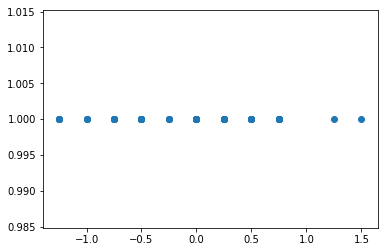

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias1_op = tf.assign(b1, 
                          tf.round(b1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_1_op = tf.assign(w2_1, 
                          tf.round(w2_1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias2_1_op = tf.assign(b2_1, 
                          tf.round(b2_1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_2_op = tf.assign(w2_2, 
                          tf.round(w2_2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias2_2_op = tf.assign(b2_2, 
                          tf.round(b2_2/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_3_op = tf.assign(w2_3, 
                          tf.round(w2_3/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias2_3_op = tf.assign(b2_3, 
                          tf.round(b2_3/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights3_1_op = tf.assign(w3_1, 
                          tf.round(w3_1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights3_2_op = tf.assign(w3_2, 
                          tf.round(w3_2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights3_3_op = tf.assign(w3_3, 
                          tf.round(w3_3/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)
_ = sess.run(rounding_bias1_op)
_ = sess.run(rounding_weights2_1_op)
_ = sess.run(rounding_bias2_1_op)
_ = sess.run(rounding_weights2_2_op)
_ = sess.run(rounding_bias2_2_op)
_ = sess.run(rounding_weights2_3_op)
_ = sess.run(rounding_bias2_3_op)

_ = sess.run(rounding_weights3_1_op)
_ = sess.run(rounding_weights3_2_op)
_ = sess.run(rounding_weights3_3_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)
b1_values = sess.run(b1)
w2_1_values = sess.run(w2_1)
b2_1_values = sess.run(b2_1)
w2_2_values = sess.run(w2_2)
b2_2_values = sess.run(b2_2)
w2_3_values = sess.run(w2_3)
b2_3_values = sess.run(b2_3)
w3_1_values = sess.run(w3_1)
w3_2_values = sess.run(w3_2)
w3_3_values = sess.run(w3_3)

kernel_values = (list(w1_values.flatten()) + 
                  list(b1_values.flatten()) +
                  list(w2_1_values.flatten()) +
                  list(b2_1_values.flatten()) +
                  list(w2_2_values.flatten()) +
                  list(b2_2_values.flatten()) +
                  list(w2_3_values.flatten()) +
                  list(b2_3_values.flatten()) +
                  list(w3_1_values.flatten()) +
                  list(w3_2_values.flatten()) +
                  list(w3_3_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))

### 3.3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)


Epoch 1 completed, average training loss is 0.19344026054275068
Testing Acc.: 0.9626000005006791
Epoch 2 completed, average training loss is 0.1147106971195899
Testing Acc.: 0.9662000009417534
Epoch 3 completed, average training loss is 0.10763085106077294
Testing Acc.: 0.9668999993801117
Epoch 4 completed, average training loss is 0.1030591461842414
Testing Acc.: 0.9666000014543533
Epoch 5 completed, average training loss is 0.10113641459766465
Testing Acc.: 0.9687000012397766
Epoch 6 completed, average training loss is 0.09865738089739655
Testing Acc.: 0.9651000013947487
Epoch 7 completed, average training loss is 0.09733838540792931
Testing Acc.: 0.9685999998450279
Epoch 8 completed, average training loss is 0.09564182294125204
Testing Acc.: 0.959500000178814
Epoch 9 completed, average training loss is 0.09405625563580543
Testing Acc.: 0.9660000011324883
Epoch 10 completed, average training loss is 0.09453650281609347
Testing Acc.: 0.966500001847744
Epoch 11 completed, average train

In [0]:
test_accuracy_bin_rate_fc(bin_rate_feed)

0.976200003027916

## 3.4 Extract conv weights

In [0]:
with open('NP_WEIGHTS_three_layers_bin_reg_lrelu25.pck', 'wb') as f:
  pickle.dump((w1_values, b1_values, w2_1_values, b2_1_values, w2_2_values, b2_2_values, w2_3_values, b2_3_values, w3_1_values, w3_2_values, w3_3_values), f)

In [0]:
w3_1_values

array([[[[ 0.25]],

        [[-0.5 ]],

        [[ 0.  ]]],


       [[[-1.25]],

        [[ 0.  ]],

        [[ 0.  ]]],


       [[[-0.75]],

        [[ 0.5 ]],

        [[ 0.25]]]], dtype=float32)

# 4 Add 3 depth separable conv layers

## 4.1 Network definition

In [0]:
def lrelu(x):
    return tf.maximum(x * 0.25, x)

In [0]:
# Define the network
def net4(input, thresh_ph, bin_rate_ph):
  # Convolution
  #conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=tf.nn.relu,
  #                   padding='SAME', scope='conv1')
  conv = slim.conv2d(input, 3, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv1')
  
  # One depth separable conv
  conv_2_1 = slim.conv2d(conv[...,:1], 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv2_1')
  conv_3_1 = slim.conv2d(conv_2_1, 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv3_1')
  conv_4_1 = slim.conv2d(conv_3_1, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv4_1')
  
  conv_2_2 = slim.conv2d(conv[...,1:2], 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv2_2')
  conv_3_2 = slim.conv2d(conv_2_2, 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv3_2')
  conv_4_2 = slim.conv2d(conv_3_2, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv4_2')
  
  conv_2_3 = slim.conv2d(conv[...,2:3], 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv2_3')
  conv_3_3 = slim.conv2d(conv_2_3, 1, [3, 3], rate=1, activation_fn=lrelu,
                     padding='SAME', scope='conv3_3')
  conv_4_3 = slim.conv2d(conv_3_3, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv4_3')
  
  
  conv3 = tf.concat([conv_3_1, conv_3_2, conv_3_3], axis=-1)
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv3, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net4(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

W0727 09:15:18.161193 139675524298624 deprecation.py:323] From <ipython-input-10-b4c113280869>:40: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0727 09:15:18.417423 139675524298624 deprecation.py:323] From <ipython-input-10-b4c113280869>:41: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0727 09:15:18.420414 139675524298624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
  
with tf.variable_scope('conv2_1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
  b2_1 = tf.get_variable('biases')
with tf.variable_scope('conv2_2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
  b2_2 = tf.get_variable('biases')
with tf.variable_scope('conv2_3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')
  b2_3 = tf.get_variable('biases')
  
with tf.variable_scope('conv3_1', reuse=True) as scope_conv:
  w3_1 = tf.get_variable('weights')
  b3_1 = tf.get_variable('biases')
with tf.variable_scope('conv3_2', reuse=True) as scope_conv:
  w3_2 = tf.get_variable('weights')
  b3_2 = tf.get_variable('biases')
with tf.variable_scope('conv3_3', reuse=True) as scope_conv:
  w3_3 = tf.get_variable('weights')
  b3_3 = tf.get_variable('biases')
  
with tf.variable_scope('conv4_1', reuse=True) as scope_conv:
  w4_1 = tf.get_variable('weights')
with tf.variable_scope('conv4_2', reuse=True) as scope_conv:
  w4_2 = tf.get_variable('weights')
with tf.variable_scope('conv4_3', reuse=True) as scope_conv:
  w4_3 = tf.get_variable('weights')

NUM_PARAM_REG = np.prod(([int(e) for e in w1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b2_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b2_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w2_3.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b2_3.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w3_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b3_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w3_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b3_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w3_3.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in b3_3.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w4_1.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w4_2.shape]))
NUM_PARAM_REG += np.prod(([int(e) for e in w4_3.shape]))

reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w2_1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b2_1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w2_2))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b2_2))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w2_3))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b2_3))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w3_1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b3_1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w3_2))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b3_2))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w3_3))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerBias(b3_3))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w4_1))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w4_2))
reg_losses = 27./NUM_PARAM_REG *tf.reduce_mean(customRegularizerConv(w4_3))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

W0727 09:15:30.544577 139675524298624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 4.2 Training

In [0]:
"""
# Reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
"""

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)
  

Epoch 1 completed, average training loss is 3.589011167883873
Testing Acc.: 0.5817999976873398
Epoch 2 completed, average training loss is 1.0101976803938548
Testing Acc.: 0.7348000019788742
Epoch 3 completed, average training loss is 0.6971283778548241
Testing Acc.: 0.8061000031232833
Epoch 4 completed, average training loss is 0.5384148597717285
Testing Acc.: 0.8574999994039536
Epoch 5 completed, average training loss is 0.42568509434660273
Testing Acc.: 0.8932000029087067
Epoch 6 completed, average training loss is 0.3460011199985941
Testing Acc.: 0.8986000001430512
Epoch 7 completed, average training loss is 0.2980815837656458
Testing Acc.: 0.9205000013113022
Epoch 8 completed, average training loss is 0.26514460316548744
Testing Acc.: 0.9229000049829483
Epoch 9 completed, average training loss is 0.24840711784859498
Testing Acc.: 0.9327000039815903
Epoch 10 completed, average training loss is 0.23284395646924774
Testing Acc.: 0.9169999998807907
Epoch 11 completed, average training

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9779000055789947


In [0]:
# Save models, for not having to fully retrain it each time.

# Testing Acc.: 0.9714000046253204 for bin reg
# 0.9679000043869018 for reg bin
saver = tf.train.Saver()
saver.save(sess, 'four_layers_bin_reg_lrelu025_bis/model.ckpt')

'four_layers_bin_reg_lrelu025_bis/model.ckpt'

In [0]:
!zip -r four_layers_bin_reg_lrelu025_bis.zip four_layers_bin_reg_lrelu025_bis

  adding: four_layers_bin_reg_lrelu025_bis/ (stored 0%)
  adding: four_layers_bin_reg_lrelu025_bis/model.ckpt.data-00000-of-00001 (deflated 11%)
  adding: four_layers_bin_reg_lrelu025_bis/checkpoint (deflated 42%)
  adding: four_layers_bin_reg_lrelu025_bis/model.ckpt.meta (deflated 90%)
  adding: four_layers_bin_reg_lrelu025_bis/model.ckpt.index (deflated 58%)


## 4.3 Re-training FC after rounding the conv kernels

### 4.3.1 Reload Network

In [0]:
!unzip four_layers_bin_reg_lrelu025.zip

Archive:  three_layers_bin_reg_lrelu02.zip
replace three_layers_bin_reg_lrelu02/model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace three_layers_bin_reg_lrelu02/model.ckpt.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([3]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net4(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('four_layers_bin_reg_lrelu025_bis')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

W0727 10:30:07.158785 139675524298624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.9779000025987625

### 4.3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
  
with tf.variable_scope('conv2_1', reuse=True) as scope_conv:
  w2_1 = tf.get_variable('weights')
  b2_1 = tf.get_variable('biases')
with tf.variable_scope('conv2_2', reuse=True) as scope_conv:
  w2_2 = tf.get_variable('weights')
  b2_2 = tf.get_variable('biases')
with tf.variable_scope('conv2_3', reuse=True) as scope_conv:
  w2_3 = tf.get_variable('weights')
  b2_3 = tf.get_variable('biases')
  
with tf.variable_scope('conv3_1', reuse=True) as scope_conv:
  w3_1 = tf.get_variable('weights')
  b3_1 = tf.get_variable('biases')
with tf.variable_scope('conv3_2', reuse=True) as scope_conv:
  w3_2 = tf.get_variable('weights')
  b3_2 = tf.get_variable('biases')
with tf.variable_scope('conv3_3', reuse=True) as scope_conv:
  w3_3 = tf.get_variable('weights')
  b3_3 = tf.get_variable('biases')
  
with tf.variable_scope('conv4_1', reuse=True) as scope_conv:
  w4_1 = tf.get_variable('weights')
with tf.variable_scope('conv4_2', reuse=True) as scope_conv:
  w4_2 = tf.get_variable('weights')
with tf.variable_scope('conv4_3', reuse=True) as scope_conv:
  w4_3 = tf.get_variable('weights')

Testing Acc.: 0.9413999971747399


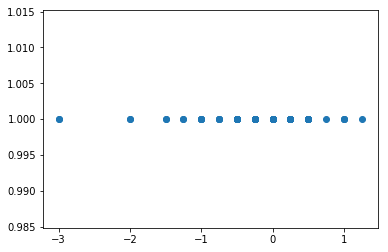

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias1_op = tf.assign(b1, 
                          tf.round(b1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)

rounding_weights2_1_op = tf.assign(w2_1, 
                          tf.round(w2_1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias2_1_op = tf.assign(b2_1, 
                          tf.round(b2_1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_2_op = tf.assign(w2_2, 
                          tf.round(w2_2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias2_2_op = tf.assign(b2_2, 
                          tf.round(b2_2/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_3_op = tf.assign(w2_3, 
                          tf.round(w2_3/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias2_3_op = tf.assign(b2_3, 
                          tf.round(b2_3/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)

rounding_weights3_1_op = tf.assign(w3_1, 
                          tf.round(w3_1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias3_1_op = tf.assign(b3_1, 
                          tf.round(b3_1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights3_2_op = tf.assign(w3_2, 
                          tf.round(w3_2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias3_2_op = tf.assign(b3_2, 
                          tf.round(b3_2/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights3_3_op = tf.assign(w3_3, 
                          tf.round(w3_3/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias3_3_op = tf.assign(b3_3, 
                          tf.round(b3_3/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)

rounding_weights4_1_op = tf.assign(w4_1, 
                          tf.round(w4_1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights4_2_op = tf.assign(w4_2, 
                          tf.round(w4_2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_weights4_3_op = tf.assign(w4_3, 
                          tf.round(w4_3/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)
_ = sess.run(rounding_bias1_op)

_ = sess.run(rounding_weights2_1_op)
_ = sess.run(rounding_bias2_1_op)
_ = sess.run(rounding_weights2_2_op)
_ = sess.run(rounding_bias2_2_op)
_ = sess.run(rounding_weights2_3_op)
_ = sess.run(rounding_bias2_3_op)

_ = sess.run(rounding_weights3_1_op)
_ = sess.run(rounding_bias3_1_op)
_ = sess.run(rounding_weights3_2_op)
_ = sess.run(rounding_bias3_2_op)
_ = sess.run(rounding_weights3_3_op)
_ = sess.run(rounding_bias3_3_op)

_ = sess.run(rounding_weights4_1_op)
_ = sess.run(rounding_weights4_2_op)
_ = sess.run(rounding_weights4_3_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)
b1_values = sess.run(b1)

w2_1_values = sess.run(w2_1)
b2_1_values = sess.run(b2_1)
w2_2_values = sess.run(w2_2)
b2_2_values = sess.run(b2_2)
w2_3_values = sess.run(w2_3)
b2_3_values = sess.run(b2_3)

w3_1_values = sess.run(w3_1)
b3_1_values = sess.run(b3_1)
w3_2_values = sess.run(w3_2)
b3_2_values = sess.run(b3_2)
w3_3_values = sess.run(w3_3)
b3_3_values = sess.run(b3_3)

w4_1_values = sess.run(w4_1)
w4_2_values = sess.run(w4_2)
w4_3_values = sess.run(w4_3)

kernel_values = (list(w1_values.flatten()) + 
                  list(b1_values.flatten()) +
                  list(w2_1_values.flatten()) +
                  list(b2_1_values.flatten()) +
                  list(w2_2_values.flatten()) +
                  list(b2_2_values.flatten()) +
                  list(w2_3_values.flatten()) +
                  list(b2_3_values.flatten()) +
                  list(w3_1_values.flatten()) +
                  list(b3_1_values.flatten()) +
                  list(w3_2_values.flatten()) +
                  list(b3_2_values.flatten()) +
                  list(w3_3_values.flatten()) + 
                  list(b3_3_values.flatten()) +
                  list(w4_1_values.flatten()) +
                  list(w4_2_values.flatten()) +
                  list(w4_3_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))

### 4.3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)


Epoch 1 completed, average training loss is 0.09854723619556656
Testing Acc.: 0.9680000001192093
Epoch 2 completed, average training loss is 0.07871715034719576
Testing Acc.: 0.9691000005602837
Epoch 3 completed, average training loss is 0.0758578354276445
Testing Acc.: 0.9691000005602837
Epoch 4 completed, average training loss is 0.07190673169344033
Testing Acc.: 0.969700001180172
Epoch 5 completed, average training loss is 0.0695606580098441
Testing Acc.: 0.9697000002861023
Epoch 6 completed, average training loss is 0.06824045459439124
Testing Acc.: 0.9729000020027161
Epoch 7 completed, average training loss is 0.06530130949574717
Testing Acc.: 0.9720000016689301
Epoch 8 completed, average training loss is 0.06511981382742912
Testing Acc.: 0.9731000015139579
Epoch 9 completed, average training loss is 0.06349364672333953
Testing Acc.: 0.9716000008583069
Epoch 10 completed, average training loss is 0.06273833142518317
Testing Acc.: 0.972300001680851
Epoch 11 completed, average train

In [0]:
test_accuracy_bin_rate_fc(bin_rate_feed)


0.9769000041484833

## 4.4 Extract conv weights

In [0]:
with open('NP_WEIGHTS_four_layers_bin_reg_lrelu25.pck', 'wb') as f:
  pickle.dump((w1_values, b1_values,
               w2_1_values, b2_1_values, w2_2_values, b2_2_values, w2_3_values, b2_3_values,
               w3_1_values, b3_1_values, w3_2_values, b3_2_values, w3_3_values, b3_3_values, 
               w4_1_values, w4_2_values, w4_3_values), f)

In [0]:
w3_1_values

array([[[[ 0.25]],

        [[-0.5 ]],

        [[ 0.  ]]],


       [[[-1.25]],

        [[ 0.  ]],

        [[ 0.  ]]],


       [[[-0.75]],

        [[ 0.5 ]],

        [[ 0.25]]]], dtype=float32)